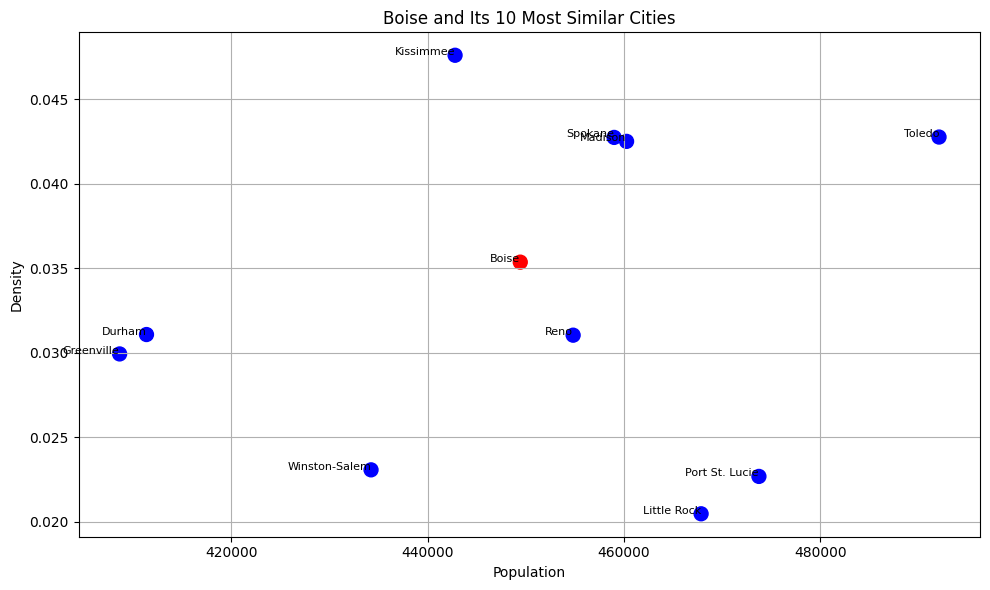

In [1]:
# Full Complete Code for City Similarity Analysis

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist

# 1. Load the dataset
file_path = "uscities.xlsx"
df = pd.read_excel(file_path)

# 2. Data Cleaning: Filter for cities with population > 50,000
cities = df[df['population'] > 50000].copy()

# 3. Feature Engineering: Log-transform population to reduce skewness
cities['log_population'] = np.log1p(cities['population'])

# 4. Select and normalize features for similarity comparison
features = ['log_population', 'density']
X = cities[features].copy()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Add normalized features back to dataframe
cities_scaled = cities.copy()
cities_scaled[features] = X_scaled

# 5. Define query cities
query_cities = ['Boise', 'Cambridge', 'El Paso']

# Find DataFrame indices for query cities
query_indices = [
    cities_scaled[cities_scaled['city_ascii'].str.contains(city, case=False)].index[0]
    for city in query_cities
]

# 6. Compute pairwise Euclidean distances between cities
distances = cdist(X_scaled, X_scaled, metric='euclidean')

# 7. Identify top 10 most similar cities for each query
top_similar = {}
for idx in query_indices:
    sim_indices = np.argsort(distances[idx])[1:11]  # Skip self
    query_name = cities_scaled.loc[idx, 'city_ascii']
    similar_df = cities_scaled.iloc[sim_indices][
        ['city_ascii', 'state_id', 'population', 'density']
    ].copy()
    similar_df['similarity_score'] = 1 - distances[idx][sim_indices]  # Higher = more similar
    top_similar[query_name] = similar_df

# 8. Combine all results into one DataFrame for output
combined_results = pd.concat(top_similar, names=['QueryCity', 'Rank']).reset_index(level=0)

# 9. Save to CSV
output_path = "city_similarity_results.csv"
combined_results.to_csv(output_path, index=False)

# 10. Visualization for Boise
query = 'Boise'
boise_similar = top_similar[query].copy()
boise_similar['QueryCity'] = False

# Add query city
boise_row = cities_scaled[cities_scaled['city_ascii'] == query][['city_ascii', 'state_id', 'population', 'density']]
boise_row['similarity_score'] = 1.0
boise_row['QueryCity'] = True
plot_df = pd.concat([boise_similar, boise_row])

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['population'], plot_df['density'], 
            c=plot_df['QueryCity'].map({True: 'red', False: 'blue'}), s=100)
for i, row in plot_df.iterrows():
    plt.text(row['population'], row['density'], row['city_ascii'], fontsize=8, ha='right')
plt.xlabel('Population')
plt.ylabel('Density')
plt.title('Boise and Its 10 Most Similar Cities')
plt.grid(True)
plt.tight_layout()
plt.savefig("boise_similar_cities_plot.png")
plt.show()

# 11. Limitations (as a comment for report):
# - Analysis is based only on population and density.
# - It excludes important factors like income, education, cultural characteristics.
# - Similarity doesn't imply policy transferability without qualitative context.
